In [20]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nitashakochar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
import nltk
from nltk import FreqDist
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy used for lemmatization
import spacy

# Tools for plotting topic model
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# FreqDist visualization
import seaborn as sns

In [22]:
import pandas as pd
with open('2sample_50000_1.json', 'r') as json_file: 
        df = pd.read_json(json_file, lines = False)
df.head()


,index,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,112311,faPVqws-x-5k2CQKDNtHxw,0,2015-10-25 16:15:23,0,N3sAgIFXLrEAIt2i7LSP-A,4,My wife and I happened on this place while exp...,0,xQyQmldNrLxTj56sA8Wyhg
1,4810863,ZkGDCVKSdf8m76cnnalL-A,0,2009-10-21 03:03:08,0,Hxs8bjX2u27wJT18Sz8JLQ,4,We came here for breakfast the last morning in...,0,k_GZxl63dzxcwgTMRxl9hA
10,4385258,OETh78qcgDltvHULowwhJg,2,2015-06-17 00:52:10,1,AlotavdKtECP-_5iZUdR9g,5,"Ate here in 2014, had the ribcap, wife had the...",2,XNzQn7mBTQgvCQeJstZP_g
100,5253196,cYwJA2A6I12KNkm2rtXd5g,0,2016-09-18 14:23:55,0,zKcAtJ01NBi7QsvN8NYUeQ,5,The Uber Burger is the best burger by far on t...,0,3tZPC9cdaJ2HKzTNO31fDw
1000,2815890,RESDUcs7fIiihp38-d6_6g,2,2014-01-20 21:07:44,2,Q7ucCng_gvscz52unZ5XbA,4,"If you're looking for a Vegas buffet, look no ...",4,VhKq24P8UcZ5eEGbum9hLA


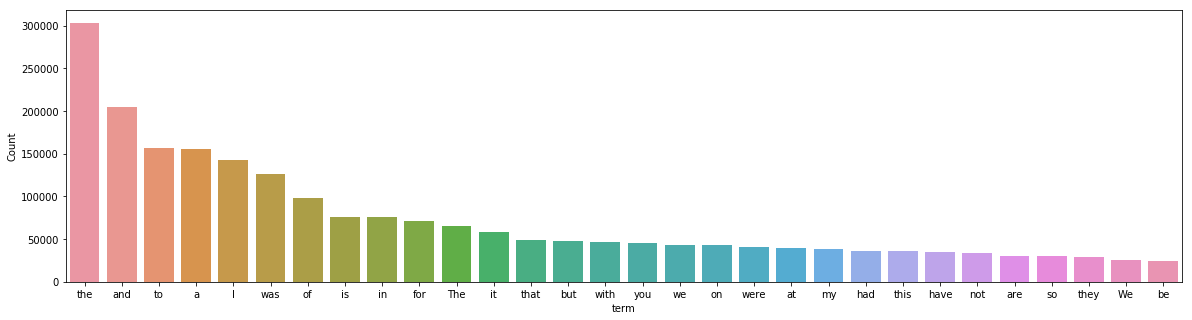

In [23]:
# function to plot most frequent terms
# freq function adapted and modified from https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
def freq_words(x, terms = 30):
    all_the_words = ' '.join([text for text in x])
    all_the_words = all_the_words.split()
    fdist = FreqDist(all_the_words)
    words_df = pd.DataFrame({'term':list(fdist.keys()), 'count':list(fdist.values())})
    # selecting top 20 most frequent words
    dt = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=dt, x= "term", y = "count")
    ax.set(ylabel = 'Count')
    plt.show() 

freq_words(df['text'])

In [24]:
# Convert to list
data = df.text.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

print(data[1:2])

<>:5: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<ipython-input-24-80e8fb5c0fad>:5: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


["We came here for breakfast the last morning in vegas. The service was fast and very nice. There was a huge selection of food, about everything you could ever think of wanting for breakfast and more. Unfortunately they switched out the food while we were eating to the lunch menu. I was hungover and tired didn't want lunch, just breakfast! So we left, probably better anyways i didn't need to eat anything more. If ever staying at the paris hotel again i would come here again."]


In [25]:
# Tokenize words and clean-up text
# deacc=True removes punctuations

def tokenize_reviews(reviews):
    for review in reviews:
        yield(gensim.utils.simple_preprocess(str(review), deacc=True))

data_words = list(tokenize_reviews(data))

print(data_words[1:2])


[['we', 'came', 'here', 'for', 'breakfast', 'the', 'last', 'morning', 'in', 'vegas', 'the', 'service', 'was', 'fast', 'and', 'very', 'nice', 'there', 'was', 'huge', 'selection', 'of', 'food', 'about', 'everything', 'you', 'could', 'ever', 'think', 'of', 'wanting', 'for', 'breakfast', 'and', 'more', 'unfortunately', 'they', 'switched', 'out', 'the', 'food', 'while', 'we', 'were', 'eating', 'to', 'the', 'lunch', 'menu', 'was', 'hungover', 'and', 'tired', 'didn', 'want', 'lunch', 'just', 'breakfast', 'so', 'we', 'left', 'probably', 'better', 'anyways', 'didn', 'need', 'to', 'eat', 'anything', 'more', 'if', 'ever', 'staying', 'at', 'the', 'paris', 'hotel', 'again', 'would', 'come', 'here', 'again']]


In [26]:
# Creating bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
trigram_mod = gensim.models.phrases.Phraser(trigram)



In [27]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
BuckleySaltonSWL = open("stopwords copy.txt").read().splitlines()
stop_words.extend([w.lower() for w in BuckleySaltonSWL])

In [28]:
# Simple preprocess comes from Gensim library found here: 
# https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html
    
nlp = spacy.load('en', disable=['parser', 'ner'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def create_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sentence in texts:
        doc = nlp(" ".join(sentence)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token) > 3])
    return texts_out

In [29]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Create bigrams
data_bigrams = create_bigrams(data_words_nostops)

# Create trigrams
data_trigrams = create_trigrams(data_bigrams)

data_lemmatized = lemmatization(data_trigrams, allowed_postags=['NOUN'])

print(data_lemmatized[:1])

[['strip', 'native', 'oklahoma', 'vegas', 'joint', 'chicken', 'waffle', 'chicken', 'waffle', 'doubt', 'chicken', 'waffle', 'syrup', 'hoisin', 'sauce', 'entree', 'biscuit', 'gill', 'pushy', 'lunchgoer', 'turn', 'atmosphere', 'country', 'loud', 'casino', 'mall', 'drink', 'chicken', 'note', 'beer', 'abita', 'purple', 'chicken', 'bottle', 'mark', 'judgment']]


In [30]:
# make each array into a string
list_of_strings=[]
for row in data_lemmatized:
    string = " ".join(row)
    list_of_strings.append(string)

list_of_strings

# make all words into 1 large string
big_string=''
for row in data_lemmatized:
    string = " ".join(row)
    big_string = big_string + string


In [31]:
import nltk
tokens = nltk.word_tokenize(big_string)

fdist = FreqDist(tokens)

In [32]:
fdist.most_common(20)

[('room', 28654),
 ('food', 23687),
 ('hotel', 15910),
 ('vegas', 10406),
 ('restaurant', 9885),
 ('night', 9206),
 ('buffet', 9091),
 ('burger', 8781),
 ('line', 7964),
 ('strip', 7845),
 ('price', 6794),
 ('casino', 6744),
 ('pool', 6081),
 ('chicken', 5883),
 ('check', 5639),
 ('drink', 5089),
 ('dinner', 4857),
 ('meat', 4784),
 ('server', 4671),
 ('menu', 4621)]

In [33]:
# create dictionary and corpus needed for topic modeling
dictionary = corpora.Dictionary(data_lemmatized)

# Create Corpus
text_corpus = data_lemmatized

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in text_corpus]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 3)]]


In [34]:
# Human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abita', 1),
  ('atmosphere', 1),
  ('beer', 1),
  ('biscuit', 1),
  ('bottle', 1),
  ('casino', 1),
  ('chicken', 5),
  ('country', 1),
  ('doubt', 1),
  ('drink', 1),
  ('entree', 1),
  ('gill', 1),
  ('hoisin', 1),
  ('joint', 1),
  ('judgment', 1),
  ('loud', 1),
  ('lunchgoer', 1),
  ('mall', 1),
  ('mark', 1),
  ('native', 1),
  ('note', 1),
  ('oklahoma', 1),
  ('purple', 1),
  ('pushy', 1),
  ('sauce', 1),
  ('strip', 1),
  ('syrup', 1),
  ('turn', 1),
  ('vegas', 1),
  ('waffle', 3)]]

In [35]:
# Building a topic model!
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=22, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

# INFER TOPICS FROM KEYWORDS HERE:

In [36]:
# Print the Keywords in each topic
# Inferring the topic from key words
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(1,
  '0.000*"chotchsky" + 0.000*"punnie" + 0.000*"oiliness" + 0.000*"boca" + '
  '0.000*"raton" + 0.000*"ackward" + 0.000*"differnt" + 0.000*"aapex" + '
  '0.000*"aver" + 0.000*"postre"'),
 (12,
  '0.240*"charge" + 0.170*"care" + 0.152*"resort_fee" + 0.079*"vacation" + '
  '0.065*"comp" + 0.036*"checking" + 0.033*"apology" + 0.033*"tram" + '
  '0.022*"soap" + 0.012*"reward"'),
 (19,
  '0.411*"customer" + 0.144*"sign" + 0.057*"bunch" + 0.048*"omelette" + '
  '0.047*"smile" + 0.047*"pillow" + 0.036*"second" + 0.032*"direction" + '
  '0.011*"comforter" + 0.000*"coupon"'),
 (4,
  '0.264*"taco" + 0.148*"pork" + 0.096*"attentive" + 0.068*"perfection" + '
  '0.049*"construction" + 0.038*"lemon" + 0.037*"ambience" + 0.031*"mission" + '
  '0.031*"studio" + 0.023*"fare"'),
 (0,
  '0.194*"show" + 0.153*"work" + 0.098*"seat" + 0.071*"bartender" + '
  '0.070*"change" + 0.051*"card" + 0.040*"request" + 0.033*"stage" + '
  '0.031*"picture" + 0.026*"hold"'),
 (17,
  '0.233*"dessert" + 0.125*"coffee"

In [37]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.47295877405936815


In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/anaconda3/envs/cs89_env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.266157  0.054785       1        1  19.047029
16    -0.107094  0.070153       2        1   6.789232
18    -0.120010  0.056328       3        1   6.779166
5     -0.107471  0.054060       4        1   6.758282
15    -0.101045 -0.365846       5        1   6.110013
13    -0.074564  0.043019       6        1   5.682283
6     -0.058658  0.037796       7        1   5.248961
2     -0.090055  0.065996       8        1   5.146971
11    -0.042614  0.035262       9        1   4.661938
7     -0.004197  0.027598      10        1   4.130344
8     -0.005050  0.027476      11        1   3.905514
20    -0.000430  0.026411      12        1   3.758017
10    -0.015262  0.028130      13        1   3.397115
3      0.031484  0.022365      14        1   3.299803
9      0.031898  0.021894      15        1   3.272032
21    -0.005001 -0.274550      16        1   3.126670
17     0.048300  0.019888      17        1   2.840638
0      0.079769  0.017040      18        1   2.494735
4      0.171069  0.010523      19        1   1.212275
12     0.188744  0.009487      20        1   1.179444
19     0.198227  0.008945      21        1   1.152736
1      0.248118  0.003240      22        1   0.006809, topic_info=     Category          Freq            Term         Total  loglift  logprob
31    Default  44739.000000            food  44739.000000  30.0000  30.0000
112   Default  44254.000000            room  44254.000000  29.0000  29.0000
28    Default  21277.000000           vegas  21277.000000  28.0000  28.0000
53    Default  16969.000000           night  16969.000000  27.0000  27.0000
79    Default  14159.000000          buffet  14159.000000  26.0000  26.0000
74    Default  17538.000000      restaurant  17538.000000  25.0000  25.0000
32    Default  26317.000000           hotel  26317.000000  24.0000  24.0000
69    Default  12267.000000          burger  12267.000000  23.0000  23.0000
270   Default  12799.000000            line  12799.000000  22.0000  22.0000
321   Default  11362.000000           price  11362.000000  21.0000  21.0000
6     Default   9075.000000         chicken   9075.000000  20.0000  20.0000
9     Default   8112.000000           drink   8112.000000  19.0000  19.0000
166   Default   7755.000000            meat   7755.000000  18.0000  18.0000
170   Default   7198.000000           pizza   7198.000000  17.0000  17.0000
83    Default   8933.000000          dinner   8933.000000  16.0000  16.0000
43    Default   6621.000000         dessert   6621.000000  15.0000  15.0000
30    Default   7945.000000       breakfast   7945.000000  14.0000  14.0000
97    Default   8034.000000          server   8034.000000  13.0000  13.0000
34    Default   7153.000000            menu   7153.000000  12.0000  12.0000
413   Default   4733.000000        customer   4733.000000  11.0000  11.0000
156   Default   6505.000000        sandwich   6505.000000  10.0000  10.0000
25    Default  12217.000000           strip  12217.000000   9.0000   9.0000
85    Default   5584.000000             fry   5584.000000   8.0000   8.0000
33    Default   6328.000000           lunch   6328.000000   7.0000   7.0000
486   Default   5591.000000           water   5591.000000   6.0000   6.0000
145   Default   4831.000000            show   4831.000000   5.0000   5.0000
70    Default   6190.000000          flavor   6190.000000   4.0000   4.0000
45    Default   6066.000000            dish   6066.000000   3.0000   3.0000
59    Default   5903.000000           steak   5903.000000   2.0000   2.0000
71    Default   5435.000000          friend   5435.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
9884  Topic22      0.002398           burps      1.421569   3.2099 -10.2521
9450  Topic22      0.002398    shaped_couch      1.421569   3.2099 -10.2521
9439  Topic22      0.002398           jesus      1.421569   3.2099 -10.2521
9

# MALLET

In [41]:
# Download: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=22, id2word=dictionary)

In [42]:
# Show Topics
pprint(ldamallet.show_topics(formatted=True))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()


[(19,
  '0.147*"pool" + 0.146*"night" + 0.022*"day" + 0.018*"chair" + '
  '0.016*"complaint" + 0.015*"morning" + 0.014*"space" + 0.014*"work" + '
  '0.013*"walk" + 0.012*"con"'),
 (5,
  '0.136*"chicken" + 0.101*"breakfast" + 0.045*"coffee" + 0.042*"waffle" + '
  '0.039*"portion" + 0.034*"bacon" + 0.030*"brunch" + 0.027*"potato" + '
  '0.026*"egg" + 0.023*"plate"'),
 (1,
  '0.142*"casino" + 0.032*"wynn" + 0.030*"strip" + 0.030*"aria" + 0.024*"shop" '
  '+ 0.023*"resort" + 0.022*"game" + 0.017*"property" + 0.017*"bellagio" + '
  '0.016*"machine"'),
 (8,
  '0.120*"meat" + 0.098*"sandwich" + 0.065*"lunch" + 0.047*"salad" + '
  '0.030*"bread" + 0.029*"sauce" + 0.023*"beef" + 0.022*"rib" + '
  '0.019*"brisket" + 0.017*"tender"'),
 (0,
  '0.155*"restaurant" + 0.103*"menu" + 0.090*"server" + 0.063*"waiter" + '
  '0.051*"dinner" + 0.047*"reservation" + 0.031*"birthday" + 0.024*"dining" + '
  '0.022*"kitchen" + 0.020*"hostess"'),
 (6,
  '0.291*"room" + 0.035*"shower" + 0.026*"hotel" + 0.024*"flo

In [43]:
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6993164018479532


In [44]:
# This function computes coherence for a different numbber of topics.
# It takes in a gensim dictionary, gensim corpus, list of texts as input, and a max num of topics (limit).
# It returns a list of LDA topic models and coherence values that correspond to an LDA model with a specific numbebro f topics
def compute_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    models_list = []
    c_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        models_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_values.append(coherencemodel.get_coherence())
    return models_list, c_values

In [45]:
models_list, c_values = compute_coherence(dictionary=dictionary, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=5)

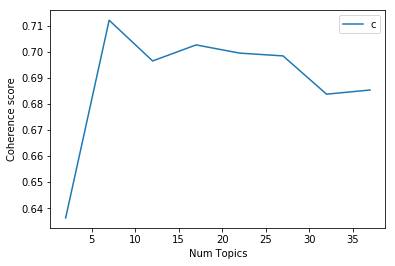

In [46]:
# Show graph
# try this with 22 becasue that's the largest number of categories here
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, c_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("c_values"), loc='best')
plt.show()

In [47]:
# Print the coherence scores
for m, cv in zip(x, c_values):
    print("Number of Topics =", m, " has a Coherence Value of", round(cv, 4))

Number of Topics = 2  has a Coherence Value of 0.6363
Number of Topics = 7  has a Coherence Value of 0.7121
Number of Topics = 12  has a Coherence Value of 0.6965
Number of Topics = 17  has a Coherence Value of 0.7026
Number of Topics = 22  has a Coherence Value of 0.6995
Number of Topics = 27  has a Coherence Value of 0.6984
Number of Topics = 32  has a Coherence Value of 0.6837
Number of Topics = 37  has a Coherence Value of 0.6853


In [51]:
# Select the model and print the topics
best_model = models_list[1]
model_topics = best_model.show_topics(formatted=False)
pprint(best_model.print_topics(num_words=10))

[(0,
  '0.174*"room" + 0.096*"hotel" + 0.035*"check" + 0.034*"pool" + 0.023*"floor" '
  '+ 0.018*"stay" + 0.016*"night" + 0.013*"front_desk" + 0.012*"shower" + '
  '0.012*"elevator"'),
 (1,
  '0.069*"vegas" + 0.065*"strip" + 0.053*"casino" + 0.024*"trip" + '
  '0.020*"hotel" + 0.019*"money" + 0.016*"parking" + 0.014*"view" + '
  '0.014*"bellagio" + 0.014*"walk"'),
 (2,
  '0.112*"food" + 0.082*"buffet" + 0.043*"dinner" + 0.040*"price" + '
  '0.038*"pizza" + 0.037*"dessert" + 0.034*"breakfast" + 0.025*"lunch" + '
  '0.022*"line" + 0.017*"plate"'),
 (3,
  '0.071*"burger" + 0.037*"chicken" + 0.029*"steak" + 0.029*"fry" + '
  '0.025*"cheese" + 0.025*"menu" + 0.018*"flavor" + 0.018*"bread" + '
  '0.016*"bacon" + 0.016*"portion"'),
 (4,
  '0.044*"night" + 0.043*"line" + 0.025*"club" + 0.022*"show" + 0.016*"music" '
  '+ 0.015*"airport" + 0.012*"seat" + 0.012*"vegas" + 0.011*"security" + '
  '0.009*"guy"'),
 (5,
  '0.049*"restaurant" + 0.041*"drink" + 0.035*"server" + 0.025*"customer" + '
  '0

In [52]:
# Showing the most dominant topic in each review - is essentially categorizing each review into a topic created by the topic model
# Modified function from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_dom_topics_(ldamodel=lda_model, corpus=corpus, texts=data):
    #Create Dataframe
    sentence_topics_df = pd.DataFrame()
    
    # Main topic in each review
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the dom topic, % contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                # Get the representation for a single topic; word_prop = word proportion
                word_prop = ldamodel.show_topic(topic_num)
                keywords_for_topic = ", ".join([word for word, proportion in word_prop])
                sentence_topics_df =  sentence_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), keywords_for_topic]), ignore_index=True)
            else:
                break
    sentence_topics_df.columns = ['Dominant Topic', '% Contribution', 'Topic Keywords']

    contents = pd.Series(texts)
    sentence_topics_df = pd.concat([sentence_topics_df, contents], axis=1)
    return(sentence_topics_df)

In [53]:
df_topic_sents_keywords = format_dom_topics_(ldamodel=best_model, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Review #', 'Dominant Topic', 'Topic % Contrib', 'Keywords', 'Text']

In [54]:
# topic distribition across documents
topic_counts = df_topic_sents_keywords['Dominant Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution



3.0    0.1852
0.0    0.1790
2.0    0.1685
6.0    0.1664
5.0    0.1097
1.0    0.0968
4.0    0.0943
Name: Dominant Topic, dtype: float64